# Lyrics to Artist

We train a neural network on lyrics from 10 different artists. Each artist has 100 songs to train on, and then we test the network

### Libraries, API, and constants setup

In [5]:
import lyricsgenius as genius
import os
import json
from sklearn.utils import shuffle
from tqdm import tqdm
import matplotlib.pylab as plt
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD

# Duncan's API key, change to your own if you are downloading data
geniusCreds = 'Lw6NjXtbU7NndUFHRCcOX9FdLhPzVokLIt9c4LWzsTxM10wF7EICGtWSSso8Ohsq'
NUM_OF_SONGS = 100

artist_names = [
    'James Taylor',
    'The Beatles',
    'Johnny Cash',
    'Van Morrison',
    'Bob Dylan',
    'Fleetwood Mac',
    'Lil Wayne',
    'J. Cole',
    'Taylor Swift',
    'Beyoncé'
]

api = genius.Genius(geniusCreds)
genius.skip_non_songs = True
genius.excluded_terms = ["(Remix)", "(Live)"]

### Download Raw Lyric Data

In [10]:
for artist_name in artist_names:
    artist = api.search_artist(artist_name, max_songs=NUM_OF_SONGS)
    artist.save_lyrics()

Searching for songs by Taylor Swift...

Song 1: "Lover"
Song 2: "Look What You Made Me Do"
Song 3: "End Game"
Song 4: "ME!"
Song 5: "You Need To Calm Down"
Song 6: "...Ready for It?"
Song 7: "Blank Space"
Song 8: "Bad Blood (Remix)"
Song 9: "Call It What You Want"
Song 10: "Delicate"
Song 11: "Style"
Song 12: "Cruel Summer"
Song 13: "Gorgeous"
Song 14: "Don’t Blame Me"
Song 15: "I Did Something Bad"
Song 16: "The Man"
Song 17: "Dress"
Song 18: "The Archer"
Song 19: "Bad Blood"
Song 20: "London Boy"
Song 21: "Miss Americana & The Heartbreak Prince"
Song 22: "Getaway Car"
Song 23: "Cornelia Street"
Song 24: "King of My Heart"
Song 25: "I Forgot That You Existed"
Song 26: "Daylight"
Song 27: "New Year’s Day"
Song 28: "Death by a Thousand Cuts"
Song 29: "So It Goes..."
Song 30: "Wildest Dreams"
Song 31: "Paper Rings"
Song 32: "This Is Why We Can’t Have Nice Things"
Song 33: "False God"
Song 34: "I Think He Knows"
Song 35: "Love Story"
Song 36: "Soon You’ll Get Better"
Song 37: "Afterglow"


### Clean the Data
Remove excess JSON data and write to a new file, just with the lyrics

In [11]:
for artist in tqdm(artist_names):
    a_mod = artist.replace(' ', '')
    filename = f'Lyrics_{a_mod}.json'
    with open(f'./data/{filename}') as f:
        data = json.load(f)
        song_obj = {}
        song_obj[artist] = []
        for song in data['songs']:
            song_obj[artist].append(song['lyrics'])
        with open(f'./data/cleaned/{artist}.json', 'w') as outfile:
            json.dump(song_obj, outfile)

  0%|          | 0/10 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: './data/Lyrics_JamesTaylor.json'

### Extract, tokenize, and one hot encode data to X, Y vectors

In [113]:
# get basic X, Y sets for training + testing
# X is song lyrics
# Y is the one-hot encoding of the artists
X = []
Y = []
NUM_OF_ARTISTS = len(list(os.listdir('./data/cleaned'))) - 1
artist_index_map = {}

def clean_word(word):
    word = word.replace('\n', '')
    word = word.replace('[', '')
    word = word.replace(']', '')
    word = word.replace(':', '')
    return word

index = 0
for filename in os.listdir('./data/cleaned'):
    with open(f'./data/cleaned/{filename}') as file:
        if filename == '.DS_Store': continue
        data = json.load(file)[filename.replace('.json', '')]
        if len(data) == 100:
            for song in data:
                
                X.append(song)
                # one hot encode artist
                one_h = np.zeros(NUM_OF_ARTISTS)
                one_h[index] = 1
                artist_index_map[index] = filename.replace('.json', '')
                Y.append(one_h)
            index += 1

# create encoding of words
# i.e. map words to numbers
big_word_list = {}
for song in X:
    for line in song.split('\n'):
        for word in line.split(' '):
            word = clean_word(word)
            if word not in big_word_list.keys():
                if (len(big_word_list.keys()) == 0):
                    big_word_list[word] = 1
                else:
                    big_word_list[word] = len(big_word_list) + 1
                
# tokenize the songs
# so we are mapping each word to it's key in the big_word_list
token_x = []
for song in X:
    new_song = []
    for line in song.split('\n'):
        for word in line.split(' '):
            word = clean_word(word)
            new_song.append(big_word_list[word])
    token_x.append(np.array(new_song))
X = token_x

# cutting off lyrics min 100 words
# to normalize network input
cutoff = 100
index = 0
new_x = []
new_y = []
for song in X:
    if (len(song) >= cutoff):
        new_x.append(song)
        new_y.append(Y[index])
    index += 1
X = new_x
Y = new_y

# trim all of the lyrics to 100 words max,
# so the network input in normalized
trimmed = []
for song in X:
    song = song[:100]
    trimmed.append(song)
X = trimmed

# convert to numpy arrays for keras
X = np.array(X)
Y = np.array(Y)

X, Y = shuffle(X, Y, random_state=0)

print(X.shape)
print(Y.shape)

(971, 100)
(971, 10)


In [114]:
X_train = X[:800]
y_train = Y[:800]

X_test = X[800:]
y_test = Y[800:]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(800, 100)
(800, 10)
(171, 100)
(171, 10)


In [103]:
def artist_from_output(out):
    index = np.argmax(out)
    return artist_index_map[index]

def tokenize_text(text):
    tokens = []
    for word in text:
        if word in big_word_list.keys():
            tokens.append(big_word_list[word])
        else:
            tokens.append(len(big_word_list) + 1)
            big_word_list[word] = len(big_word_list) + 1
    tokens = np.array(tokens)
    return tokens

def text_from_tokens(tokens):
    text = []
    for token in tokens:
        index = 0
        for entry in big_word_list.values():
            if token == entry:
                text.append(list(big_word_list.keys())[index])
            index += 1
    return text

### Create model, train and evaluate

In [138]:
model = Sequential([
    Dense(100, input_shape=(100,)),
    Activation('softmax'),
    Dense(250),
    Activation('softmax'),
    Dense(1000),
    Activation('softmax'),
    Dense(500),
    Activation('softmax'),
    Dense(NUM_OF_ARTISTS)
])

model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['accuracy'])

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 100)               10100     
_________________________________________________________________
activation_47 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 250)               25250     
_________________________________________________________________
activation_48 (Activation)   (None, 250)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 1000)              251000    
_________________________________________________________________
activation_49 (Activation)   (None, 1000)              0         
_________________________________________________________________
dense_64 (Dense)             (None, 500)             

In [139]:
history = model.fit(
        X_train, y_train,
        epochs=1000,
        verbose=True,
        validation_data=(X_test, y_test),
        batch_size=64)

Train on 800 samples, validate on 171 samples
Epoch 1/1000
800/800 [==============================] - 0s 472us/step - loss: 0.0964 - accuracy: 0.1063 - val_loss: 0.0941 - val_accuracy: 0.0877
Epoch 2/1000
800/800 [==============================] - 0s 254us/step - loss: 0.0930 - accuracy: 0.1037 - val_loss: 0.0920 - val_accuracy: 0.0877
Epoch 3/1000
800/800 [==============================] - 0s 257us/step - loss: 0.0914 - accuracy: 0.1063 - val_loss: 0.0909 - val_accuracy: 0.0877
Epoch 4/1000
800/800 [==============================] - 0s 245us/step - loss: 0.0906 - accuracy: 0.0950 - val_loss: 0.0904 - val_accuracy: 0.0877
Epoch 5/1000
800/800 [==============================] - 0s 287us/step - loss: 0.0902 - accuracy: 0.1075 - val_loss: 0.0902 - val_accuracy: 0.0702
Epoch 6/1000
800/800 [==============================] - 0s 238us/step - loss: 0.0901 - accuracy: 0.1050 - val_loss: 0.0901 - val_accuracy: 0.0702
Epoch 7/1000
800/800 [==============================] - 0s 278us/step - loss: 

800/800 [==============================] - 0s 206us/step - loss: 0.0900 - accuracy: 0.1025 - val_loss: 0.0902 - val_accuracy: 0.0877
Epoch 57/1000
800/800 [==============================] - 0s 198us/step - loss: 0.0900 - accuracy: 0.0925 - val_loss: 0.0902 - val_accuracy: 0.0877
Epoch 58/1000
800/800 [==============================] - 0s 209us/step - loss: 0.0900 - accuracy: 0.0938 - val_loss: 0.0902 - val_accuracy: 0.0702
Epoch 59/1000
800/800 [==============================] - 0s 206us/step - loss: 0.0900 - accuracy: 0.1013 - val_loss: 0.0902 - val_accuracy: 0.0877
Epoch 60/1000
800/800 [==============================] - 0s 199us/step - loss: 0.0900 - accuracy: 0.1000 - val_loss: 0.0901 - val_accuracy: 0.0877
Epoch 61/1000
800/800 [==============================] - 0s 229us/step - loss: 0.0900 - accuracy: 0.1050 - val_loss: 0.0901 - val_accuracy: 0.0877
Epoch 62/1000
800/800 [==============================] - 0s 201us/step - loss: 0.0900 - accuracy: 0.0838 - val_loss: 0.0901 - val_ac

Epoch 112/1000
800/800 [==============================] - 0s 219us/step - loss: 0.0900 - accuracy: 0.1088 - val_loss: 0.0901 - val_accuracy: 0.0702
Epoch 113/1000
800/800 [==============================] - 0s 181us/step - loss: 0.0900 - accuracy: 0.0925 - val_loss: 0.0902 - val_accuracy: 0.0877
Epoch 114/1000
800/800 [==============================] - 0s 182us/step - loss: 0.0900 - accuracy: 0.1050 - val_loss: 0.0901 - val_accuracy: 0.0877
Epoch 115/1000
800/800 [==============================] - 0s 188us/step - loss: 0.0900 - accuracy: 0.1025 - val_loss: 0.0902 - val_accuracy: 0.0936
Epoch 116/1000
800/800 [==============================] - 0s 188us/step - loss: 0.0900 - accuracy: 0.0975 - val_loss: 0.0902 - val_accuracy: 0.0936
Epoch 117/1000
800/800 [==============================] - 0s 183us/step - loss: 0.0900 - accuracy: 0.1025 - val_loss: 0.0902 - val_accuracy: 0.0877
Epoch 118/1000
800/800 [==============================] - 0s 184us/step - loss: 0.0900 - accuracy: 0.0913 - val_

800/800 [==============================] - 0s 212us/step - loss: 0.0900 - accuracy: 0.1063 - val_loss: 0.0902 - val_accuracy: 0.0702
Epoch 168/1000
800/800 [==============================] - 0s 198us/step - loss: 0.0900 - accuracy: 0.1037 - val_loss: 0.0902 - val_accuracy: 0.0702
Epoch 169/1000
800/800 [==============================] - 0s 206us/step - loss: 0.0900 - accuracy: 0.1088 - val_loss: 0.0901 - val_accuracy: 0.0936
Epoch 170/1000
800/800 [==============================] - 0s 205us/step - loss: 0.0900 - accuracy: 0.0925 - val_loss: 0.0902 - val_accuracy: 0.0702
Epoch 171/1000
800/800 [==============================] - 0s 226us/step - loss: 0.0900 - accuracy: 0.1000 - val_loss: 0.0902 - val_accuracy: 0.0877
Epoch 172/1000
800/800 [==============================] - 0s 232us/step - loss: 0.0900 - accuracy: 0.0887 - val_loss: 0.0901 - val_accuracy: 0.0877
Epoch 173/1000
800/800 [==============================] - 0s 222us/step - loss: 0.0900 - accuracy: 0.0850 - val_loss: 0.0902 - 

800/800 [==============================] - 0s 202us/step - loss: 0.0900 - accuracy: 0.1000 - val_loss: 0.0902 - val_accuracy: 0.0877
Epoch 223/1000
800/800 [==============================] - 0s 203us/step - loss: 0.0900 - accuracy: 0.1063 - val_loss: 0.0901 - val_accuracy: 0.0702
Epoch 224/1000
800/800 [==============================] - 0s 194us/step - loss: 0.0900 - accuracy: 0.0988 - val_loss: 0.0902 - val_accuracy: 0.0702
Epoch 225/1000
800/800 [==============================] - 0s 205us/step - loss: 0.0900 - accuracy: 0.1025 - val_loss: 0.0902 - val_accuracy: 0.0702
Epoch 226/1000
800/800 [==============================] - 0s 207us/step - loss: 0.0900 - accuracy: 0.1000 - val_loss: 0.0902 - val_accuracy: 0.0702
Epoch 227/1000
800/800 [==============================] - 0s 206us/step - loss: 0.0900 - accuracy: 0.1088 - val_loss: 0.0901 - val_accuracy: 0.0877
Epoch 228/1000
800/800 [==============================] - 0s 203us/step - loss: 0.0900 - accuracy: 0.0950 - val_loss: 0.0902 - 

800/800 [==============================] - 0s 197us/step - loss: 0.0900 - accuracy: 0.1000 - val_loss: 0.0902 - val_accuracy: 0.0702
Epoch 278/1000
800/800 [==============================] - 0s 198us/step - loss: 0.0900 - accuracy: 0.0950 - val_loss: 0.0901 - val_accuracy: 0.0702
Epoch 279/1000
800/800 [==============================] - 0s 198us/step - loss: 0.0900 - accuracy: 0.1013 - val_loss: 0.0902 - val_accuracy: 0.0702
Epoch 280/1000
800/800 [==============================] - 0s 203us/step - loss: 0.0900 - accuracy: 0.0938 - val_loss: 0.0901 - val_accuracy: 0.0702
Epoch 281/1000
800/800 [==============================] - 0s 192us/step - loss: 0.0900 - accuracy: 0.1025 - val_loss: 0.0902 - val_accuracy: 0.0702
Epoch 282/1000
800/800 [==============================] - 0s 205us/step - loss: 0.0900 - accuracy: 0.1075 - val_loss: 0.0902 - val_accuracy: 0.0702
Epoch 283/1000
800/800 [==============================] - 0s 204us/step - loss: 0.0900 - accuracy: 0.1088 - val_loss: 0.0902 - 

800/800 [==============================] - 0s 199us/step - loss: 0.0900 - accuracy: 0.0875 - val_loss: 0.0902 - val_accuracy: 0.0702
Epoch 333/1000
800/800 [==============================] - 0s 194us/step - loss: 0.0900 - accuracy: 0.1088 - val_loss: 0.0902 - val_accuracy: 0.0877
Epoch 334/1000
800/800 [==============================] - 0s 202us/step - loss: 0.0900 - accuracy: 0.1000 - val_loss: 0.0902 - val_accuracy: 0.0702
Epoch 335/1000
800/800 [==============================] - 0s 200us/step - loss: 0.0900 - accuracy: 0.1013 - val_loss: 0.0901 - val_accuracy: 0.0702
Epoch 336/1000
800/800 [==============================] - 0s 198us/step - loss: 0.0900 - accuracy: 0.1000 - val_loss: 0.0901 - val_accuracy: 0.0702
Epoch 337/1000
800/800 [==============================] - 0s 194us/step - loss: 0.0900 - accuracy: 0.0938 - val_loss: 0.0901 - val_accuracy: 0.0702
Epoch 338/1000
800/800 [==============================] - 0s 201us/step - loss: 0.0900 - accuracy: 0.1063 - val_loss: 0.0901 - 

800/800 [==============================] - 0s 200us/step - loss: 0.0900 - accuracy: 0.1037 - val_loss: 0.0901 - val_accuracy: 0.0702
Epoch 388/1000
800/800 [==============================] - 0s 202us/step - loss: 0.0900 - accuracy: 0.1037 - val_loss: 0.0901 - val_accuracy: 0.0702
Epoch 389/1000
800/800 [==============================] - 0s 211us/step - loss: 0.0900 - accuracy: 0.0825 - val_loss: 0.0902 - val_accuracy: 0.0702
Epoch 390/1000
800/800 [==============================] - 0s 197us/step - loss: 0.0900 - accuracy: 0.0938 - val_loss: 0.0902 - val_accuracy: 0.0702
Epoch 391/1000
800/800 [==============================] - 0s 194us/step - loss: 0.0900 - accuracy: 0.1063 - val_loss: 0.0901 - val_accuracy: 0.0702
Epoch 392/1000
800/800 [==============================] - 0s 197us/step - loss: 0.0900 - accuracy: 0.1025 - val_loss: 0.0902 - val_accuracy: 0.0702
Epoch 393/1000
800/800 [==============================] - 0s 199us/step - loss: 0.0900 - accuracy: 0.1088 - val_loss: 0.0901 - 

800/800 [==============================] - 0s 223us/step - loss: 0.0900 - accuracy: 0.1050 - val_loss: 0.0901 - val_accuracy: 0.0877
Epoch 443/1000
800/800 [==============================] - 0s 220us/step - loss: 0.0900 - accuracy: 0.0925 - val_loss: 0.0901 - val_accuracy: 0.0877
Epoch 444/1000
800/800 [==============================] - 0s 197us/step - loss: 0.0900 - accuracy: 0.0950 - val_loss: 0.0901 - val_accuracy: 0.0936
Epoch 445/1000
800/800 [==============================] - 0s 200us/step - loss: 0.0900 - accuracy: 0.1037 - val_loss: 0.0901 - val_accuracy: 0.0936
Epoch 446/1000
800/800 [==============================] - 0s 200us/step - loss: 0.0900 - accuracy: 0.1088 - val_loss: 0.0901 - val_accuracy: 0.0702
Epoch 447/1000
800/800 [==============================] - 0s 195us/step - loss: 0.0900 - accuracy: 0.0938 - val_loss: 0.0901 - val_accuracy: 0.0877
Epoch 448/1000
800/800 [==============================] - 0s 198us/step - loss: 0.0900 - accuracy: 0.1037 - val_loss: 0.0901 - 

800/800 [==============================] - 0s 203us/step - loss: 0.0900 - accuracy: 0.0938 - val_loss: 0.0902 - val_accuracy: 0.0702
Epoch 498/1000
800/800 [==============================] - 0s 202us/step - loss: 0.0900 - accuracy: 0.0988 - val_loss: 0.0901 - val_accuracy: 0.0702
Epoch 499/1000
800/800 [==============================] - 0s 211us/step - loss: 0.0900 - accuracy: 0.0962 - val_loss: 0.0902 - val_accuracy: 0.0702
Epoch 500/1000
800/800 [==============================] - 0s 202us/step - loss: 0.0900 - accuracy: 0.1088 - val_loss: 0.0901 - val_accuracy: 0.0702
Epoch 501/1000
800/800 [==============================] - 0s 206us/step - loss: 0.0900 - accuracy: 0.0988 - val_loss: 0.0902 - val_accuracy: 0.0702
Epoch 502/1000
800/800 [==============================] - 0s 207us/step - loss: 0.0900 - accuracy: 0.0862 - val_loss: 0.0902 - val_accuracy: 0.0702
Epoch 503/1000
800/800 [==============================] - 0s 198us/step - loss: 0.0900 - accuracy: 0.1088 - val_loss: 0.0902 - 

800/800 [==============================] - 0s 196us/step - loss: 0.0900 - accuracy: 0.1075 - val_loss: 0.0901 - val_accuracy: 0.0877
Epoch 553/1000
800/800 [==============================] - 0s 196us/step - loss: 0.0900 - accuracy: 0.1013 - val_loss: 0.0901 - val_accuracy: 0.0877
Epoch 554/1000
800/800 [==============================] - 0s 206us/step - loss: 0.0900 - accuracy: 0.0862 - val_loss: 0.0901 - val_accuracy: 0.0702
Epoch 555/1000
800/800 [==============================] - 0s 193us/step - loss: 0.0900 - accuracy: 0.1063 - val_loss: 0.0901 - val_accuracy: 0.0702
Epoch 556/1000
800/800 [==============================] - 0s 203us/step - loss: 0.0900 - accuracy: 0.0887 - val_loss: 0.0901 - val_accuracy: 0.1111
Epoch 557/1000
800/800 [==============================] - 0s 204us/step - loss: 0.0900 - accuracy: 0.0962 - val_loss: 0.0901 - val_accuracy: 0.0702
Epoch 558/1000
800/800 [==============================] - 0s 203us/step - loss: 0.0900 - accuracy: 0.1000 - val_loss: 0.0901 - 

800/800 [==============================] - 0s 222us/step - loss: 0.0900 - accuracy: 0.0988 - val_loss: 0.0902 - val_accuracy: 0.0702
Epoch 608/1000
800/800 [==============================] - 0s 217us/step - loss: 0.0900 - accuracy: 0.0900 - val_loss: 0.0901 - val_accuracy: 0.0702
Epoch 609/1000
800/800 [==============================] - 0s 211us/step - loss: 0.0900 - accuracy: 0.1037 - val_loss: 0.0902 - val_accuracy: 0.0702
Epoch 610/1000
800/800 [==============================] - 0s 310us/step - loss: 0.0900 - accuracy: 0.1037 - val_loss: 0.0902 - val_accuracy: 0.0877
Epoch 611/1000
800/800 [==============================] - 0s 247us/step - loss: 0.0900 - accuracy: 0.0850 - val_loss: 0.0901 - val_accuracy: 0.0702
Epoch 612/1000
800/800 [==============================] - 0s 297us/step - loss: 0.0900 - accuracy: 0.0925 - val_loss: 0.0902 - val_accuracy: 0.0702
Epoch 613/1000
800/800 [==============================] - 0s 289us/step - loss: 0.0900 - accuracy: 0.1063 - val_loss: 0.0902 - 

800/800 [==============================] - 0s 206us/step - loss: 0.0900 - accuracy: 0.0950 - val_loss: 0.0901 - val_accuracy: 0.0936
Epoch 663/1000
800/800 [==============================] - 0s 235us/step - loss: 0.0900 - accuracy: 0.0988 - val_loss: 0.0901 - val_accuracy: 0.0702
Epoch 664/1000
800/800 [==============================] - 0s 258us/step - loss: 0.0900 - accuracy: 0.1037 - val_loss: 0.0901 - val_accuracy: 0.0936
Epoch 665/1000
800/800 [==============================] - 0s 243us/step - loss: 0.0900 - accuracy: 0.0950 - val_loss: 0.0902 - val_accuracy: 0.0936
Epoch 666/1000
800/800 [==============================] - 0s 198us/step - loss: 0.0900 - accuracy: 0.0913 - val_loss: 0.0902 - val_accuracy: 0.0702
Epoch 667/1000
800/800 [==============================] - 0s 230us/step - loss: 0.0900 - accuracy: 0.1088 - val_loss: 0.0901 - val_accuracy: 0.0936
Epoch 668/1000
800/800 [==============================] - 0s 240us/step - loss: 0.0900 - accuracy: 0.0825 - val_loss: 0.0901 - 

800/800 [==============================] - 0s 246us/step - loss: 0.0900 - accuracy: 0.1088 - val_loss: 0.0902 - val_accuracy: 0.0702
Epoch 718/1000
800/800 [==============================] - 0s 245us/step - loss: 0.0900 - accuracy: 0.1013 - val_loss: 0.0901 - val_accuracy: 0.0877
Epoch 719/1000
800/800 [==============================] - 0s 200us/step - loss: 0.0900 - accuracy: 0.0838 - val_loss: 0.0902 - val_accuracy: 0.0702
Epoch 720/1000
800/800 [==============================] - 0s 221us/step - loss: 0.0900 - accuracy: 0.0887 - val_loss: 0.0902 - val_accuracy: 0.0702
Epoch 721/1000
800/800 [==============================] - 0s 200us/step - loss: 0.0900 - accuracy: 0.1025 - val_loss: 0.0902 - val_accuracy: 0.0702
Epoch 722/1000
800/800 [==============================] - 0s 239us/step - loss: 0.0900 - accuracy: 0.0862 - val_loss: 0.0901 - val_accuracy: 0.0702
Epoch 723/1000
800/800 [==============================] - 0s 222us/step - loss: 0.0900 - accuracy: 0.1050 - val_loss: 0.0901 - 

800/800 [==============================] - 0s 231us/step - loss: 0.0900 - accuracy: 0.1088 - val_loss: 0.0902 - val_accuracy: 0.0936
Epoch 773/1000
320/800 [===========>..................] - ETA: 0s - loss: 0.0901 - accuracy: 0.0812

KeyboardInterrupt: 

In [115]:
for i in range(20):
    print(artist_from_output(Y[i]))
    print(text_from_tokens(X[i][:10]))

# inp = tokenize_text(sample_text)
# print(inp.shape)
# print(get_artist_from_output(Y[2]))
# x_val = np.array([X[2]])

# output = model.predict(x_val)
# get_artist_from_output(output)

Johnny Cash
['Verse', '1', 'Six', 'foot', 'six', 'he', 'stood', 'on', 'the', 'ground']
J. Cole
['Verse', '1', 'Yeah', 'Yeah', '', 'Look,', 'I', 'just', 'shed', 'tears']
Taylor Swift
['Verse', '1', 'I', 'never', 'trust', 'a', 'narcissist,', 'but', 'they', 'love']
Lil Wayne
['Intro', 'Kendrick', 'Lamar', 'I', 'got', 'a', 'story', 'to', 'tell,', 'you']
Bob Dylan
['Verse', '1', 'Buckets', 'of', 'rain', 'Buckets', 'of', 'tears', 'Got', 'all']
Lil Wayne
['Chorus', 'Why', 'me?', 'Oh', 'why,', 'oh', 'why,', 'oh', 'why', 'me?']
Lil Wayne
['Intro', 'Lil', 'Wayne', 'Young', 'Money!', 'Yeah', 'Four', 'Ahem!', '', 'Verse']
Johnny Cash
['Verse', 'From', 'his', 'hands', 'it', 'came', 'down', 'From', 'the', 'side']
Van Morrison
["Haven't", 'heard', 'your', 'voice', 'in', 'quite', 'a', 'while', "Haven't", 'seen']
Fleetwood Mac
['Verse', '1', "It's", 'not', 'that', 'funny', 'is', 'it', 'When', 'you']
Taylor Swift
['Verse', '1', 'It', 'was', 'so', 'nice', 'throwing', 'big', 'parties', 'Jump']
Johnny Cash

In [119]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9000
Testing Accuracy:  0.9000


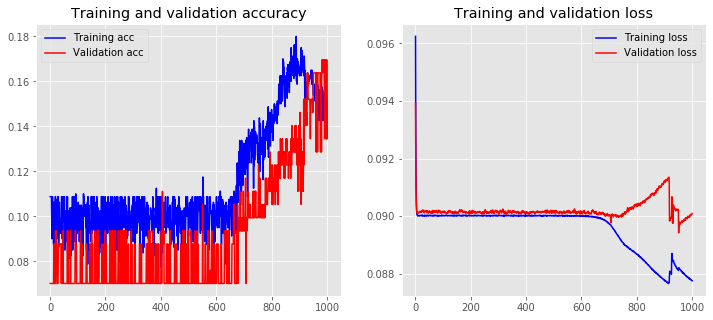

In [131]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
plot_history(history)